# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 9: Neural Networks Continued

**Harvard University**<br/>
**Fall 2018**<br/>
**Section Leaders:** Mehul Smriti Raje, Ken Arnold, Karan Motwani, Cecilia Garraffo<br/>
**Instructors:** Pavlos Protopapas, Kevin Rader <br/>
**Author:** Mehul Smriti Raje

In this section, we will revisit some of the problems we did in previous sections and try to do them again using Keras. The goal is to familiarize you with building Neural Networks using Keras. The exercises below will help you be able to answer parts of Homework 9.

Specifically, we will: 
    
    1. Use Keras to build a NN for linear regression and extend it to MLP.
    2. Use Keras to build a NN that solves a classification problem
    
This notebook can also be run on Google Colab at https://colab.research.google.com/. Colab is helpful if your machine does not have a GPU and you want to try out more complex models, though it has a memory limit. JupyterHub and JupyterLab are other useful options, as are AWS, Google Cloud, etc. Feel free to explore and tell us if you liked something/found any platform configuration interesting or useful and why. 

In [1]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import shuffle

Using TensorFlow backend.


Neural Networks are flexible structures that can be used to solve probelms of different complexities.

## 1. Linear Regression as a Neural Net

Let's first load the Titanic dataset from Section 3 and do the same pre-processing, as described before.

In [2]:
# Loading dataset and keeping a copy of the original
titanic = sns.load_dataset("titanic")

# Selecting predictors which are not redundant and don't have missing values
titanic = titanic[['age', 'sex', 'class', 'embark_town', 'alone', 'fare', 'alive']]
titanic = titanic.dropna()

# Remove outliers
titanic = titanic[titanic.fare < 100]

# Replacing columns with categorical variables
titanic = pd.get_dummies(titanic, columns=['sex', 'class'], drop_first=True)

In [3]:
# Use 4 predictors
X = titanic[['age', 'sex_male', 'class_Second', 'class_Third']]

# Normalising variables (note: this is learning normalization params using test data, but we're just exploring here.)
X = ((X - X.mean())/(X.std()))

# Define our regression task
y_reg = titanic.fare.values.reshape(-1,1)

/Users/pwong/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


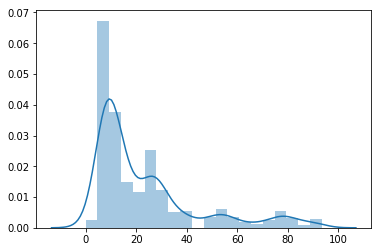

In [4]:
sns.distplot(y_reg)

In [5]:
X_train, X_val, y_train_reg, y_val_reg = train_test_split(
    X, y_reg, test_size=1/3, random_state=0)

In [6]:
print(X_train.shape, y_train_reg.shape)
X_train.head()

(442, 4) (442, 1)


,age,sex_male,class_Second,class_Third
608,-0.516021,-1.381811,1.683412,-1.071045
721,-0.861196,0.722598,-0.593137,0.932262
385,-0.792161,0.722598,1.683412,-1.071045
273,0.519504,0.722598,-0.593137,-1.071045
336,-0.032776,0.722598,-0.593137,-1.071045


Now, we fit a multiple linear regression model as before, on our numerical predictors.

In [8]:
linreg_sm = sm.OLS(y_train_reg, sm.add_constant(X_train)).fit()
linreg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     150.4
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           8.85e-81
Time:                        11:14:20   Log-Likelihood:                -1790.4
No. Observations:                 442   AIC:                             3591.
Df Residuals:                     437   BIC:                             3611.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           24.1693      0.666     36.296      0.000      22.861      25.478
age             -2.6490      0.733     -3.615      0.000      -4.089      -1.209
sex_male        -2.1448      0.674     -3.184      0.002      -3.469      -0.821
class_Second   -15.4677      0.888    -17.415      0.000     -17.213     -13.722
class_Third    -21.9663      0.961    -22.864      0.000     -23.855     -20.078
==============================================================================
Omnibus:                       83.833   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.864
Skew:                           0.994   Prob(JB):                     1.96e-40
Kurtosis:                       5.444   Cond. No.                         2.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note: we get an R^2 of 0.58 and, intercept of about 24, and coefficients of about \[-2.7, -2.1, -15.5, -21.9\].

Now, let's try to build a neural network for this linear regression. 

Let's first answer some questions to make this easier for us.

**Question 1:** What is the input-output size we should use to build our model?

In [8]:
print('Each input sample has dimensionality: ', X_train.shape[1])
print('Each output sample has dimensionality: ', y_train_reg.shape[1])

Each input sample has dimensionality:  4
Each output sample has dimensionality:  1


Do you recall the feed-forward network we made in Section 6?

**Question 2:** What transformation will help us get linear regression?

**Ans:** A linear transformation can be obtained by mapping the input to the output layer without using any non-linear transformations.

### Building a NN for this linear transformation

In [9]:
trials = {} # We'll keep track of our results here.

In [10]:
batch_size = 32
epochs = 40

# reset the model 
linreg_nn = Sequential()

# single layer
linreg_nn.add(
    Dense(1, activation='linear', input_shape=(X_train.shape[1],)))

# Summary 
linreg_nn.summary()

# compile it 
linreg_nn.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# fit it
trials['linreg'] = linreg_nn.fit(
    X_train.values, y_train_reg,
    epochs=epochs,
    validation_data=(X_val, y_val_reg), verbose=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


**Question**: Why does the output shape and the number of params make sense?

**Answer**: The output is a single scalar (1) for each input sample (`None`). To get 1 output from 4 inputs requires $4*1=4$ weights plus one bias term for each output, so 5 params.

MSE: train=194.0, val=214.4


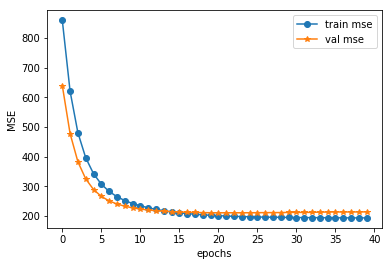

In [11]:
# Plotting the train and validation errors
plt.plot(trials['linreg'].history['mean_squared_error'], '-o', label = 'train mse')
plt.plot(trials['linreg'].history['val_mean_squared_error'], '-*', label = 'val mse')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend();

print("MSE: train={:.1f}, val={:.1f}".format(
    trials['linreg'].history['mean_squared_error'][-1],
    trials['linreg'].history['val_mean_squared_error'][-1]))

**Question**: When I first tried this, I got validation MSE much lower than train MSE. I checked and they were being computed completely correctly. Why might that have happened? (Hint: both MSEs were around 2000...)

In [12]:
# This happens to be slightly different from the *training* MSE reported in the log. The difference is due to a subtlety in how error is logged *during* an epoch.
train_mse = np.mean((linreg_nn.predict(X_train) - y_train_reg) ** 2)
train_mse

193.4575943275504

In [13]:
np.mean((linreg_nn.predict(X_val) - y_val_reg) ** 2)

214.36590034734365

In [14]:
# train R^2
1 - train_mse / np.var(y_train_reg)

0.57856417058393617

Does that R^2 number look familiar?

**Ok, what just happened here?**

We just created a neural network where the input layer takes a 5-dimensional input (4 parameters and 1 constant) and output layer produces a 1-dimensional output (regression value). The mapping is activated by a `linear` activation function. Optimisation of coeffients are done using `sgd` or stochastic gradient descent where the `mse` of fit is optimised.

**Question 3:** Why did we choose the activation function?

**Ans:** We want to produce a linear transformation, which motivates us to pick the `linear` activation.

**Question 4:** Why did we normalise our data?

**Ans:** For a single linear layer, it didn't matter much. But when we add a nonlinearity, the scale of whatever gets passed through the nonlinearity will matter a lot.

**Question 5:** How do we pick the number of epochs and batch size?

**Ans:** The number of epochs usually depends on the complexity of function being fitted and the structure of model. The batch size is often governed by the number of parameters one is trying to fit, since it determines how much memory is required for the backward pass.

**Question 6:** Why dooes the training MSE keep decreasing with the number of epochs, while the validation MSE flattens out?

**Ans:** The NN is likely overfitting.

What function is the linear regression actually computing?

In [12]:
weights, bias = linreg_nn.get_weights()
print("NN model weights:", weights.flatten())
print("NN model bias:", bias)
print("Statsmodels weights:", linreg_sm.params.values)

NN model weights: [ -2.3540208  -2.2422895 -14.790656  -21.21727  ]
NN model bias: [24.12215]
Statsmodels weights: [ 24.16932019  -2.6490289   -2.14478285 -15.46766422 -21.96628353]


Question: In what ways are these similar or different? Why?

In [14]:
linreg_sm.predict(sm.add_constant(X_train.values)[:4])

array([25.98838135, 13.59695769, 22.20638358, 53.94464295])

In [15]:
# Predict the first 4 outputs
linreg_nn.predict(X_train.values[:4])

array([[26.261173],
       [13.521987],
       [22.192518],
       [52.776485]], dtype=float32)

In [16]:
# Let's do this ourselves in NumPy

# output layer
y_pred = np.dot(X_train.values, weights) + bias
y_pred[:4]


array([[26.2611735 ],
       [13.52198818],
       [22.19251829],
       [52.77648701]])

## From linear regression to MLP

Now recall our MLP from section 6: we also had a linear output layer, but we added some hidden nodes. Let's do that in Keras.

In [35]:
X_train.values.shape, y_train_reg.shape, X_val.shape, y_val_reg.shape

((442, 4), (442, 1), (222, 4), (222, 1))

In [17]:
batch_size = 32
epochs = 40
n_hidden = 5

# reset the model 
model = Sequential()

# HIDDEN LAYER (new this time)
model.add(
    Dense(
        n_hidden,
        activation='sigmoid', input_shape=(X_train.shape[1],)))

# output layer (same as last time, except now we don't need to specify input_shape)
model.add(Dense(1, activation = 'linear'))

# Summary 
model.summary()

# compile it 
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# fit it
trials['mlp'] = model.fit(X_train.values, y_train_reg, epochs=epochs, validation_data=(X_val, y_val_reg), verbose=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 25        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


**Question**: Why do those shapes and #params make sense?

Linear Regression             : mean_squared_error             = 193.98
MLP (5 hidden) Regression     : mean_squared_error             = 183.48
Linear Regression             : val_mean_squared_error         = 214.39
MLP (5 hidden) Regression     : val_mean_squared_error         = 204.12


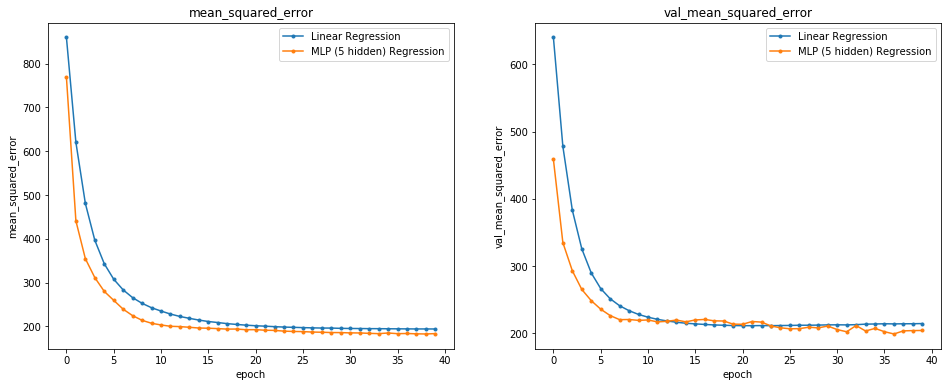

In [18]:
# Plotting the train and validation errors
metrics_to_plot = ['mean_squared_error', 'val_mean_squared_error']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

trials_to_plot = [
    ('Linear Regression', 'linreg'),
    ('MLP (5 hidden) Regression', 'mlp')
]

for ax, metric in zip(axs, metrics_to_plot):
    for title, trial_name in trials_to_plot:
        h = trials[trial_name].history[metric]
        ax.plot(h, marker='.', label=title)
        ax.set(xlabel="epoch", ylabel=metric, title=metric)
        ax.legend()

        print(f"{title:30s}: {metric:30s} = {h[-1]:.2f}")


How did our training and validation error compare with the linear model?

In [19]:
weights_hidden, bias_hidden = model.layers[0].get_weights()
weights_output, bias_output = model.layers[1].get_weights()

print(weights_hidden.shape, bias_hidden.shape)
print(weights_output.shape, bias_output.shape)

(4, 5) (5,)
(5, 1) (1,)


In [20]:
# Let's do this ourselves in NumPy

# defining activation function
sigmoid = lambda x: (1/(1 + np.exp(-x)))

# hidden layer
hidden_activations = np.dot(X_train, weights_hidden) + bias_hidden
hidden_layer_outputs = sigmoid(hidden_activations)

# output layer
y_pred = np.dot(hidden_layer_outputs, weights_output) + bias_output
print(y_pred[:4])

[[22.79467529]
 [13.95592297]
 [26.72937339]
 [50.71044494]]


In [21]:
# Predict the first 4 outputs
print(model.predict(X_train.values[:4]))


[[22.794674]
 [13.955924]
 [26.729372]
 [50.710445]]


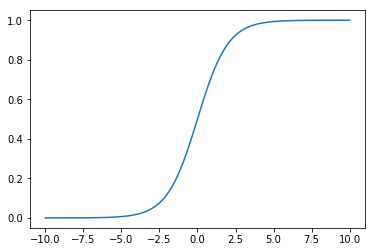

In [22]:
xx = np.linspace(-10, 10, 100)
plt.plot(xx, sigmoid(xx))

## Classification

Doing classification instead of regression is as easy as changing the loss!

In [23]:
# Change the output to a classification task
y_clf = titanic.alive == 'yes'
y_clf = y_clf.astype(int)

# same train-test split
X_train, X_val, y_train_clf, y_val_clf = train_test_split(
    X, y_clf, test_size=1/3, random_state=0)


In [24]:
y_train_clf[:10]

608    1
721    0
385    0
273    0
336    0
439    0
139    0
418    0
600    1
0      0
Name: alive, dtype: int64

In [25]:
# Logistic Regression = sigmoid activation + binary-cross-entropy loss.
batch_size = 32
epochs = 500

# reset the model 
logreg_nn = Sequential()

# single layer
logreg_nn.add(Dense(
    1, activation='sigmoid', input_shape=(X_train.shape[1],)))

# Summary 
logreg_nn.summary()

# compile it 
logreg_nn.compile(
    optimizer='sgd',
    loss='binary_crossentropy', metrics=['accuracy'])

# fit it 
logreg_history = logreg_nn.fit(X_train.values, y_train_clf, epochs=epochs, validation_data=(X_val, y_val_clf), verbose=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


Loss: train=0.433
Accuracy: train=0.826


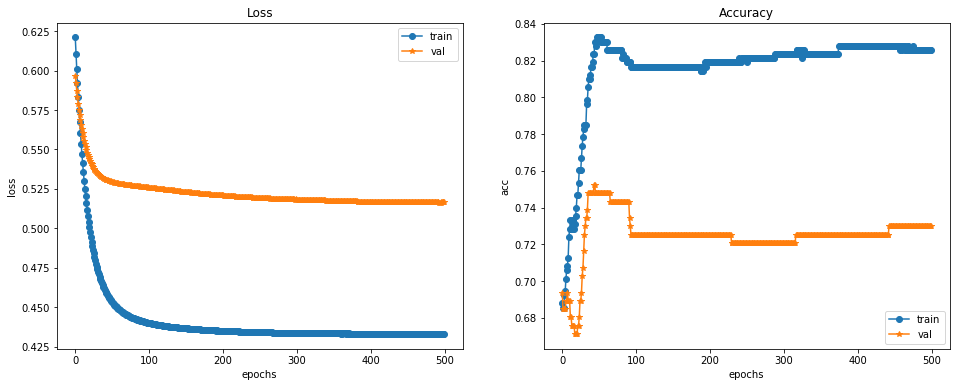

In [26]:
# Plotting the train and validation errors
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plot_data = [
    ('Loss', 'loss'),
    ('Accuracy', 'acc')
]
for ax, (title, metric) in zip(axs, plot_data):
    ax.plot(logreg_history.history[metric], '-o', label='train')
    ax.plot(logreg_history.history['val_'+metric], '-*', label='val')
    ax.set(xlabel='epochs', ylabel=metric, title=title)
    ax.legend()

    print("{}: train={:.3f}".format(
        title,
        logreg_history.history[metric][-1]))

In [27]:
sklearn_clf = LogisticRegression(C=1e6, multi_class='multinomial', solver='lbfgs').fit(X_train.values, y_train_clf)
sklearn_clf.score(X_train.values, y_train_clf)

0.8280542986425339

In [28]:
weights, bias = logreg_nn.get_weights()

In [29]:
# Let's do this ourselves in NumPy

# defining activation function
sigmoid = lambda x: (1/(1 + np.exp(-x)))

# output layer
y_pred = sigmoid(
    np.dot(X_train, weights) + bias)
y_pred[:4]


array([[0.85825776],
       [0.12622951],
       [0.30117047],
       [0.39289681]])

In [30]:
logreg_nn.predict(X_train[:4])

array([[0.8582578 ],
       [0.12622951],
       [0.30117047],
       [0.39289677]], dtype=float32)

In [31]:
sklearn_clf.predict_proba(X_train.values[:4])

array([[0.28729876, 0.71270124],
       [0.72664773, 0.27335227],
       [0.60409152, 0.39590848],
       [0.54767552, 0.45232448]])

In [32]:
sklearn_clf.coef_

array([[-0.31652555, -0.67405513, -0.28395378, -0.61070231]])

In [33]:
weights.flatten()

array([-0.6070095, -1.3354079, -0.5283309, -1.1669017], dtype=float32)

## Regularisation

**Question 7:** What happens if we increase the number of hidden nodes in the regression problem above?


Building a model with 100 hidden nodes:

In [36]:
batch_size = 32
epochs = 40
n_hidden = 100

# reset the model 
model = Sequential()

# HIDDEN LAYER (new this time)
model.add(Dense(n_hidden, activation='sigmoid', input_shape=(X_train.shape[1],)))

# output layer (same as last time, except now we don't need to specify input_shape)
model.add(Dense(1, activation = 'linear'))

# Summary 
model.summary()

# compile it 
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# fit it
trials['mlp_100'] = model.fit(X_train.values, y_train_reg, epochs=epochs, validation_data=(X_val, y_val_reg), verbose=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


Linear Regression             : mean_squared_error             = 193.95
MLP (5 hidden) Regression     : mean_squared_error             = 184.51
MLP (100 hidden) Regression   : mean_squared_error             = 194.43
Linear Regression             : val_mean_squared_error         = 214.37
MLP (5 hidden) Regression     : val_mean_squared_error         = 211.27
MLP (100 hidden) Regression   : val_mean_squared_error         = 214.37


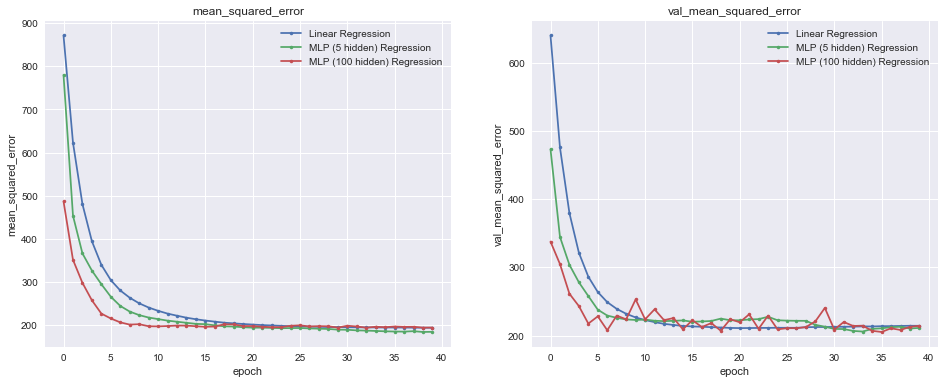

In [37]:
# Plotting the train and validation errors
metrics_to_plot = ['mean_squared_error', 'val_mean_squared_error']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

trials_to_plot = [
    ('Linear Regression', 'linreg'),
    ('MLP (5 hidden) Regression', 'mlp'),
    ('MLP (100 hidden) Regression', 'mlp_100')
]

for ax, metric in zip(axs, metrics_to_plot):
    for title, trial_name in trials_to_plot:
        h = trials[trial_name].history[metric]
        ax.plot(h, marker='.', label=title)
        ax.set(xlabel="epoch", ylabel=metric, title=metric)
        ax.legend()

        print(f"{title:30s}: {metric:30s} = {h[-1]:.2f}")


**Question 8:** What happens if we increase the number of hidden layers?


Building a model with 10 hidden layers having 5 units each (You may need to run this on a GPU - Eg. Google Colab)

In [38]:
batch_size = 32
epochs = 40
n_hidden = 10

# reset the model 
model = Sequential()

# HIDDEN LAYER (new this time)
model.add(Dense(n_hidden, activation='sigmoid', input_shape=(X_train.shape[1],)))

# more hidden layers
for layer in range(10):
    model.add(Dense(n_hidden, activation = 'sigmoid'))
    
# output layer (same as last time, except now we don't need to specify input_shape)
model.add(Dense(1, activation = 'linear'))    

# Summary 
model.summary()

# compile it 
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# fit it
trials['mlp_5x10'] = model.fit(X_train.values, y_train_reg, epochs=epochs, validation_data=(X_val, y_val_reg), verbose=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
__________

Linear Regression             : mean_squared_error             = 193.95
MLP (5 hidden) Regression     : mean_squared_error             = 184.51
MLP (5 hidden, 10 layers) Regression: mean_squared_error             = 460.75
Linear Regression             : val_mean_squared_error         = 214.37
MLP (5 hidden) Regression     : val_mean_squared_error         = 211.27
MLP (5 hidden, 10 layers) Regression: val_mean_squared_error         = 411.91


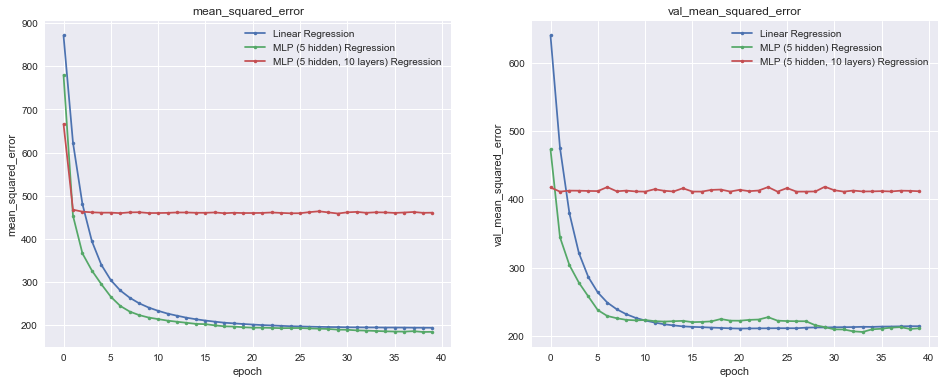

In [39]:
# Plotting the train and validation errors
metrics_to_plot = ['mean_squared_error', 'val_mean_squared_error']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

trials_to_plot = [
    ('Linear Regression', 'linreg'),
    ('MLP (5 hidden) Regression', 'mlp'),
    ('MLP (5 hidden, 10 layers) Regression', 'mlp_5x10')
]

for ax, metric in zip(axs, metrics_to_plot):
    for title, trial_name in trials_to_plot:
        h = trials[trial_name].history[metric]
        ax.plot(h, marker='.', label=title)
        ax.set(xlabel="epoch", ylabel=metric, title=metric)
        ax.legend()

        print(f"{title:30s}: {metric:30s} = {h[-1]:.2f}")


From both the above experiments, we can see that NNs can overfit very quickly.

**Question 9:** Based on the above, what are some obvious methods of regularising NNs?

**Ans:** Choosing the right number of hidden layers and hidden nodes! Unfortunately, picking the right number of parameters is a hard problem itself.

**Question 10:** Does this give you a hint of another method to prevent overfitting?

**Ans:** Stopping the process early could likely be helpful. This is known as 'early stopping' and is typically used in combination with other regularisation techniques. As intution suggests, it means 'Stopping the process when the model starts overfitting'.

**Question 11:** Think of how we prevented overfitting and helped regularise parameters in regression. Can you remember any? (Hint: Norms)

**Ans:** Using L2 regularisation can be helpful in regularising parameters, like we have observed in regression.